In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("mf_analysis").getOrCreate()
spark

In [61]:
import json
import datetime  
import pandas as pd


dateValue = str(datetime.datetime.now().strftime("%d-%m-%Y"))
filename = "./data/mutual_funds_{}.json".format(dateValue)


with open(filename) as f:
    lines = f.read().splitlines()
    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']


df_inter['json_element'].apply(json.loads)
df_final = pd.json_normalize(df_inter['json_element'].apply(json.loads))

df = spark.createDataFrame(df_final)
for column in df.columns:
    if column.find('.') != -1:
        df = df.withColumnRenamed(column, column.replace('.','_'))
df = df.replace(float("nan"),0)
df.limit(2).toPandas()

,name,link,rating,category,category_code,asset_value,expense_ratio,fund_house,risk,risk_grade,...,fund_risk_sortino,fund_risk_beta,fund_risk_alpha,category_risk_mean,category_risk_std_dev,category_risk_sharpe,category_risk_sortino,category_risk_beta,category_risk_alpha,credit_rating_Term Deposit
0,ABSL Active Debt Multi Manager FoF Dir,/funds/16883/aditya-birla-sun-life-active-debt...,3,Debt: Dynamic Bond,DT-DB,7,0.19,Aditya Birla Sun Life Mutual Fund,Moderate,Low,...,1.66,0.66,0.98,6.61,3.35,0.57,1.17,1.13,0.01,0.0
1,ABSL Corporate Bond Dir,/funds/15926/aditya-birla-sun-life-corporate-b...,5,Debt: Corporate Bond,DT-CB,20205,0.30,Aditya Birla Sun Life Mutual Fund,Moderately Low,Below Average,...,4.06,0.63,2.57,7.45,2.89,1.18,2.31,0.60,1.54,0.0


In [16]:
from pyspark.sql.functions import *
df = df.withColumn("sharpe_ratio_rank",dense_rank().over(Window.orderBy(df['fund_risk_sharpe'].desc())))
df = df.withColumn("alpha_rank",dense_rank().over(Window.orderBy(df['fund_risk_alpha'].desc())))
df = df.withColumn("beta_rank",dense_rank().over(Window.orderBy(df['fund_risk_beta'].asc())))
df = df.withColumn("std_dev_rank",dense_rank().over(Window.orderBy(df['fund_risk_std_dev'].asc())))
df = df.withColumn("mean_rank",dense_rank().over(Window.orderBy(df['fund_risk_mean'].desc())))

df.select('name','fund_risk_sharpe', 'sharpe_ratio_rank','fund_risk_alpha','alpha_rank','fund_risk_beta','beta_rank','fund_risk_std_dev','std_dev_rank','fund_risk_mean','mean_rank').limit(10).toPandas()

,name,fund_risk_sharpe,sharpe_ratio_rank,fund_risk_alpha,alpha_rank,fund_risk_beta,beta_rank,fund_risk_std_dev,std_dev_rank,fund_risk_mean,mean_rank
0,Edelweiss Banking and PSU Debt Dir,1.40,84,7.84,1,2.92,143,3.15,99,9.56,1
1,IDFC GSF Investment Dir,0.94,106,1.24,116,0.85,79,4.48,138,9.35,2
2,Edelweiss Govt Securities Dir,1.14,94,1.96,91,0.58,55,3.51,112,9.15,3
3,PGIM India Ultra ST Dir,2.01,58,6.84,2,2.43,138,1.99,62,9.14,4
4,L&T Triple Ace Bond Dir,1.00,104,1.90,95,1.61,118,3.98,126,9.13,5
5,DSP Govt Securities Dir,0.92,107,1.12,120,0.79,76,4.23,135,9.03,6
6,Axis Banking & PSU Debt Dir,1.96,59,6.48,5,2.22,132,1.98,61,9.02,7
7,Kotak Dynamic Bond Dir,1.33,87,2.35,70,1.12,99,2.86,91,8.95,8
8,SBI Magnum Medium Duration Dir,1.67,71,2.72,62,0.79,76,2.24,72,8.89,9
9,Axis Dynamic Bond Dir,1.12,96,1.99,88,1.32,108,3.31,108,8.84,10


In [27]:
from pyspark.sql.types import *

# df = df.filter('category_code == "DT-LD"')
import numpy as np
def calculate_growth(df):

    growth_1y = 1 if df[0] > df[4] else 0
    growth_3y = 1 if df[1] > df[5] else 0
    growth_5y = 1 if df[2] > df[6] else 0
    growth_7y = 1 if df[3] > df[7] else 0
    growth_10y = 1 if df[4] > df[8] else 0
    
    g_vals = [4,3,2,1]
    print(df)
    trend = 0;
    for i in g_vals:
        diff = df[i-1] - df[i]
        if diff > 0:
            trend = trend + 1
        elif diff < 0:
            trend = trend - 1
        print(diff,df[i], df[i-1], trend)
        
    growth = 5 - (growth_1y + growth_3y + growth_5y + growth_7y + growth_10y)
    trend_growth = 5 - trend
    
    return growth + trend_growth

calculate_growth_udf = udf(lambda data: calculate_growth(data), IntegerType())
print([col for col in df.columns if col.find('growth')> 0])

df = df.withColumn("trend_growth", calculate_growth_udf(array([col for col in df.columns if col.find('growth')> 0])))

df.limit(2).toPandas()

['fund_growth_1y', 'fund_growth_3y', 'fund_growth_5y', 'fund_growth_7y', 'fund_growth_10y', 'cat_growth_1y', 'cat_growth_3y', 'cat_growth_5y', 'cat_growth_7y', 'cat_growth_10y']


,name,link,rating,category,category_code,asset_value,expense_ratio,fund_house,risk,risk_grade,...,fund_risk_beta,fund_risk_alpha,category_risk_mean,category_risk_std_dev,category_risk_sharpe,category_risk_sortino,category_risk_beta,category_risk_alpha,credit_rating_Term Deposit,trend_growth
0,ABSL Active Debt Multi Manager FoF Dir,/funds/16883/aditya-birla-sun-life-active-debt...,3,Debt: Dynamic Bond,DT-DB,7,0.19,Aditya Birla Sun Life Mutual Fund,Moderate,Low,...,0.66,0.98,6.61,3.35,0.57,1.17,1.13,0.01,0.0,7
1,ABSL Corporate Bond Dir,/funds/15926/aditya-birla-sun-life-corporate-b...,5,Debt: Corporate Bond,DT-CB,20205,0.30,Aditya Birla Sun Life Mutual Fund,Moderately Low,Below Average,...,0.63,2.57,7.45,2.89,1.18,2.31,0.60,1.54,0.0,7


In [28]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *

df = df.withColumn("credit_rating_rank",dense_rank().over(Window.orderBy(df['credit_rating_AAA'].desc()))) 

df = df.withColumn("asset_value_rank",dense_rank().over(Window.orderBy(df['asset_value'].desc())))
df = df.withColumn("expense_ratio_rank",dense_rank().over(Window.orderBy(df['expense_ratio'].asc())))
# df = df.withColumn("expense_ratio_rank",when(df.expense_ratio <= 0.5, 1).when((0.5 < df.expense_ratio) & (df.expense_ratio <= 1) , 2).when((1 < df.expense_ratio) & (df.expense_ratio <= 1.5) , 3).otherwise(4))

df = df.withColumn("risk_rank", when(df.risk == 'Low', 1).when(df.risk == 'Moderately Low', 3).otherwise(3))
# ranked = df.withColumn("best_rank", dense_rank().over(Window.orderBy('risk_num').orderBy('expense_ratio_rank').orderBy('asset_value_rank')))

df = df.withColumn("sharpe_ratio_rank",dense_rank().over(Window.orderBy(df['fund_risk_sharpe'].desc())))
df = df.withColumn("alpha_rank",dense_rank().over(Window.orderBy(df['fund_risk_alpha'].desc())))
df = df.withColumn("beta_rank",dense_rank().over(Window.orderBy(df['fund_risk_beta'].asc())))
df = df.withColumn("std_dev_rank",dense_rank().over(Window.orderBy(df['fund_risk_std_dev'].asc())))
df = df.withColumn("mean_rank",dense_rank().over(Window.orderBy(df['fund_risk_mean'].desc())))

df = df.withColumn('total_rank', F.expr('risk_rank + credit_rating_rank + asset_value_rank + \
                    expense_ratio_rank  + trend_growth + sharpe_ratio_rank + \
                    alpha_rank+ beta_rank + std_dev_rank+ mean_rank '))
df.orderBy(df['rating'].desc(), df['total_rank'].asc()).limit(10).toPandas()

,name,link,rating,category,category_code,asset_value,expense_ratio,fund_house,risk,risk_grade,...,credit_rating_rank,asset_value_rank,expense_ratio_rank,risk_rank,sharpe_ratio_rank,alpha_rank,beta_rank,std_dev_rank,mean_rank,total_rank
0,Axis Banking & PSU Debt Dir,/funds/15680/axis-banking-and-psu-debt-fund-di...,5,Debt: Banking and PSU,DT-BK & PSU,16059,0.31,Axis Mutual Fund,Moderately Low,Below Average,...,4,22,27,3,60,6,135,61,9,332
1,Kotak Corporate Bond Dir,/funds/17470/kotak-corporate-bond-fund-standar...,5,Debt: Corporate Bond,DT-CB,6586,0.32,Kotak Mahindra Mutual Fund,Moderately Low,Low,...,30,55,28,3,48,62,41,44,22,340
2,ABSL Corporate Bond Dir,/funds/15926/aditya-birla-sun-life-corporate-b...,5,Debt: Corporate Bond,DT-CB,20205,0.30,Aditya Birla Sun Life Mutual Fund,Moderately Low,Below Average,...,29,13,26,3,64,68,62,54,20,346
3,ABSL Low Duration Dir,/funds/15725/aditya-birla-sun-life-low-duratio...,5,Debt: Low Duration,DT-LD,14808,0.40,Aditya Birla Sun Life Mutual Fund,Moderately Low,Below Average,...,73,23,36,3,40,38,55,34,40,348
4,Axis Short Term Dir,/funds/15752/axis-short-term-fund-direct-plan,5,Debt: Short Duration,DT-SD,9375,0.30,Axis Mutual Fund,Moderately Low,Below Average,...,37,41,26,3,61,22,106,52,20,375
5,ABSL Savings Dir,/funds/15922/aditya-birla-sun-life-savings-fun...,5,Debt: Ultra Short Duration,DT-USD,16218,0.34,Aditya Birla Sun Life Mutual Fund,Moderately Low,Average,...,96,20,30,3,36,58,47,28,66,393
6,Kotak Bond Short-term Dir,/funds/16339/kotak-bond-short-term-fund-direct...,5,Debt: Short Duration,DT-SD,12848,0.34,Kotak Mahindra Mutual Fund,Moderately Low,Below Average,...,44,28,30,3,67,18,122,53,25,397
7,Axis Treasury Advantage Dir,/funds/15760/axis-treasury-advantage-fund-dire...,5,Debt: Low Duration,DT-LD,7439,0.30,Axis Mutual Fund,Moderately Low,Below Average,...,86,51,26,3,34,34,82,33,48,405
8,ICICI Pru Ultra Short Term Dir,/funds/17404/icici-prudential-ultra-short-term...,5,Debt: Ultra Short Duration,DT-USD,6940,0.39,ICICI Prudential Mutual Fund,Moderate,Average,...,123,54,35,3,22,61,33,26,55,421
9,LIC MF Banking & PSU Debt Dir,/funds/16974/lic-mf-banking-and-psu-debt-fund-...,5,Debt: Banking and PSU,DT-BK & PSU,1713,0.28,LIC Mutual Fund,Moderate,Low,...,51,108,24,3,58,15,119,50,17,449


In [88]:
import numpy as np
import pandas as pd
import sklearn

from typing import Dict, Tuple
from sklearn.base import BaseEstimator

class RuleAugmentedEstimator(BaseEstimator):
    """Augments sklearn estimators with rule-based logic.
    This class is a wrapper class for sklearn estimators with the additional
    possibility of adding rule-based logic to the underlying estimator.
    The provided rules are hard-coded and take precedence over the underlying
    estimator's predictions.
    """

    def __init__(self, base_model: BaseEstimator, rules: Dict, **base_params):
        """Initializes the RuleAugmentedEstimator instance.
        Initializes the rule-augmented estimator by supplying the underlying
        sklearn estimator as well as the hard-coded rules.
        Args:
            base_model: The underlying sklearn estimator.
              Must implement a fit and predict method.
            rules: The hard-coded rules in the format of a dictionary,
              with keys being the pandas dataframe column name, and the values
              being a tuple in the following form:
              
              (comparison operator, value, return value)
              Acceptable comparison operators are:
              "=", "<", ">", "<=", ">="
              Example:
              
              {"House Type": [
                  ("=", "Penthouse", 1.0),
                  ("=", "Shack", 0.0)
               ],
               "House Price": [
                   ("<", 1000.0, 0.0),
                   (">=", 500000.0, 1.0)
              ]}
            **base_params: Optional keyword arguments which will be passed on
            to the ``base_model``.
        Examples:
            The below example illustrates how an instance of the 
            RuleAugmentedEstimator class can be initialized with a trained 
            sklearn GradientBoostingRegressor instance.
            >>> gbr = GradientBoostingRegressor()
            >>> rules = {"House Type": [
                            ("=", "Penthouse", 1.0),
                            ("=", "Shack", 0.0)
                         ],
                         "House Price": [
                            ("<", 1000.0, 0.0),
                            (">=", 500000.0, 1.0)
                        ]}
            >>> ra_estimator = RuleAugmentedEstimator(gbr, rules)
        """

        self.rules = rules
        self.base_model = base_model
        self.base_model.set_params(**base_params)

    def __repr__(self):
        return "Rule Augmented Estimator:\n\n\t Base Model: {}\n\t Rules: {}".format(self.base_model, self.rules)

    def __str__(self):
         return self.__str__
   
    def _get_base_model_data(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        """Filters the trainig data for data points not affected by the rules."""
        
        train_x = X

        for category, rules in self.rules.items():

            if category not in train_x.columns.values: continue

            for rule in rules:

                if rule[0] == "=":
                    train_x = train_x.loc[train_x[category] != rule[1]]

                elif rule[0] == "<":
                    train_x = train_x.loc[train_x[category] >= rule[1]]

                elif rule[0] == ">":
                    train_x = train_x.loc[train_x[category] <= rule[1]]

                elif rule[0] == "<=":
                    train_x = train_x.loc[train_x[category] > rule[1]]

                elif rule[0] == ">=":
                    train_x = train_x.loc[train_x[category] < rule[1]]

                else:
                    print("Invalid rule detected: {}".format(rule))
                
        indices = train_x.index.values
        train_y = y.iloc[indices]
        
        train_x = train_x.reset_index(drop=True)
        train_y = train_y.reset_index(drop=True)
        
        return train_x, train_y   

    def fit(self, X: pd.DataFrame, y: pd.Series, **kwargs):
        """Fits the estimator to the data.
        
        Fits the estimator to the data, only training the underlying estimator
        on data which isn't affected by the hard-coded rules.
        
        Args:
            X: The training feature data.
            y: The training label data.
            **kwargs: Optional keyword arguments passed to the underlying
            estimator's fit function.
            
    """
        train_x, train_y = self._get_base_model_data(X, y)
        self.base_model.fit(train_x, train_y, **kwargs)
    
    def predict(self, X: pd.DataFrame) -> np.array:
        """Gets predictions for the provided feature data.
        
        The predicitons are evaluated using the provided rules wherever possible
        otherwise the underlying estimator is used.
        
        Args:
            X: The feature data to evaluate predictions for.
        
        Returns:
            np.array: Evaluated predictions.
        """
        
        p_X = X.copy()
        p_X['prediction'] = np.nan

        for category, rules in self.rules.items():

            if category not in p_X.columns.values: continue

            for rule in rules:

                if rule[0] == "=":
                    p_X.loc[p_X[category] == rule[1], 'prediction'] = rule[2]

                elif rule[0] == "<":
                    p_X.loc[p_X[category] < rule[1], 'prediction'] = rule[2]

                elif rule[0] == ">":
                    p_X.loc[p_X[category] > rule[1], 'prediction'] = rule[2]

                elif rule[0] == "<=":
                    p_X.loc[p_X[category] <= rule[1], 'prediction'] = rule[2]

                elif rule[0] == ">=":
                    p_X.loc[p_X[category] >= rule[1], 'prediction'] = rule[2]

                else:
                    print("Invalid rule detected: {}".format(rule))

        if len(p_X.loc[p_X['prediction'].isna()].index != 0):

            base_X = p_X.loc[p_X['prediction'].isna()].copy()
            base_X.drop('prediction', axis=1, inplace=True)
            p_X.loc[p_X['prediction'].isna(), 'prediction'] = self.base_model.predict(base_X)

        return p_X['prediction'].values
    
    def get_params(self, deep: bool = True) -> Dict:
        """Return the model's and base model's parameters.
        Args:
            deep: Whether to recursively return the base model's parameters.
        Returns
            Dict: The model's parameters.
        """
        
        params = {'base_model': self.base_model,
                  'outcome_range': self.outcome_range,
                  'rules': self.rules
                 }
    
        params.update(self.base_model.get_params(deep=deep))
        return params
    
    def set_params(self, **params):
        """Sets parameters for the model and base model.
        Args:
            **params: Optional keyword arguments.
        """
                  
        parameters = params
        param_keys = parameters.keys()
        
        if 'base_model' in param_keys:
            value = parameters.pop('base_model')
            self.base_model = value
            
        if 'rules' in param_keys:
            value = parameters.pop('rules')
            self.rules = value
        
        self.base_model.set_params(**parameters)

In [108]:
from sklearn.datasets import load_iris

iris_dataset = load_iris()

X, y = iris_dataset.data, iris_dataset.target
X, y

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

In [101]:
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
# gbr = GradientBoostingRegressor()
rules = {
             "Beta rank": [
                ("<", 1, 0.0),
                (">=", 1, 1.0)
            ]}
# ra_estimator = RuleAugmentedEstimator(gbr, rules)

npd = df.select('fund_risk_beta','rating').toPandas()
X, y = npd['fund_risk_beta'], npd['rating']


X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)
print(X_train.column)
exit()
gbc = GradientBoostingClassifier(n_estimators=50)
hybrid_model = RuleAugmentedEstimator(gbc, rules)
hybrid_model.fit(X_train, y_train)
predictions = hybrid_model.predict(X_test)
predictions

AttributeError: 'numpy.ndarray' object has no attribute 'column'

In [81]:
from pyspark.ml.stat import Correlation
vector_col = "features"
matrix = Correlation.corr(final_df, vector_col, 'pearson')

result = matrix.collect()[0]["pearson({})".format(vector_col)].values
pd = pd.DataFrame(result.reshape(-1, len(input_columns)), columns=input_columns, index=input_columns)
pd

,rating,asset_value,expense_ratio,fund_growth_1y,fund_growth_3y,fund_growth_5y,fund_growth_7y,fund_growth_10y,cat_growth_1y,cat_growth_3y,...,fund_risk_sortino,fund_risk_beta,fund_risk_alpha,category_risk_mean,category_risk_std_dev,category_risk_sharpe,category_risk_sortino,category_risk_beta,category_risk_alpha,credit_rating_Term Deposit
rating,1.000000,0.207258,-0.098686,0.344970,0.446727,0.300776,0.230204,-0.058676,0.028343,0.024042,...,0.456866,0.210945,0.390424,0.028237,0.009546,0.006256,0.012832,0.007945,0.003873,-0.036185
asset_value,0.207258,1.000000,-0.220630,0.001083,0.134644,0.082916,0.104993,-0.026836,-0.080421,0.055276,...,0.333860,0.066485,0.164036,0.068553,-0.268101,0.290047,0.188095,0.068882,0.180925,-0.029264
expense_ratio,-0.098686,-0.220630,1.000000,-0.107216,-0.122687,0.058356,0.027465,-0.052990,0.001539,0.007576,...,-0.315323,-0.187761,-0.347510,-0.231638,0.586905,-0.538493,-0.465778,-0.233134,-0.492519,0.099039
fund_growth_1y,0.344970,0.001083,-0.107216,1.000000,0.699395,0.555453,0.344713,-0.029005,0.453594,0.285370,...,0.143707,0.518331,0.662786,0.392905,-0.012262,-0.018976,0.030817,0.325338,0.271958,0.020038
fund_growth_3y,0.446727,0.134644,-0.122687,0.699395,1.000000,0.878063,0.609343,-0.001122,0.377635,0.610517,...,0.450796,0.626573,0.796741,0.408334,-0.057815,0.100492,0.116612,0.331888,0.280019,-0.014840
fund_growth_5y,0.300776,0.082916,0.058356,0.555453,0.878063,1.000000,0.759007,-0.007958,0.373162,0.700119,...,0.349144,0.482210,0.575336,0.360520,0.102902,-0.008273,0.023834,0.261610,0.165364,0.001489
fund_growth_7y,0.230204,0.104993,0.027465,0.344713,0.609343,0.759007,1.000000,0.004017,0.404427,0.687186,...,0.344044,0.256275,0.289114,0.385519,0.013803,0.066026,0.088287,0.287520,0.195688,-0.030310
fund_growth_10y,-0.058676,-0.026836,-0.052990,-0.029005,-0.001122,-0.007958,0.004017,1.000000,-0.052619,0.010145,...,-0.011624,0.004465,0.005625,-0.003245,-0.082376,0.093743,0.042798,0.013910,0.025164,-0.001407
cat_growth_1y,0.028343,-0.080421,0.001539,0.453594,0.377635,0.373162,0.404427,-0.052619,1.000000,0.607333,...,0.042991,0.286474,0.257186,0.862436,-0.018390,-0.051700,0.056833,0.713045,0.589135,0.000241
cat_growth_3y,0.024042,0.055276,0.007576,0.285370,0.610517,0.700119,0.687186,0.010145,0.607333,1.000000,...,0.335652,0.272470,0.250424,0.654085,-0.078551,0.144539,0.171436,0.546179,0.445495,-0.023186


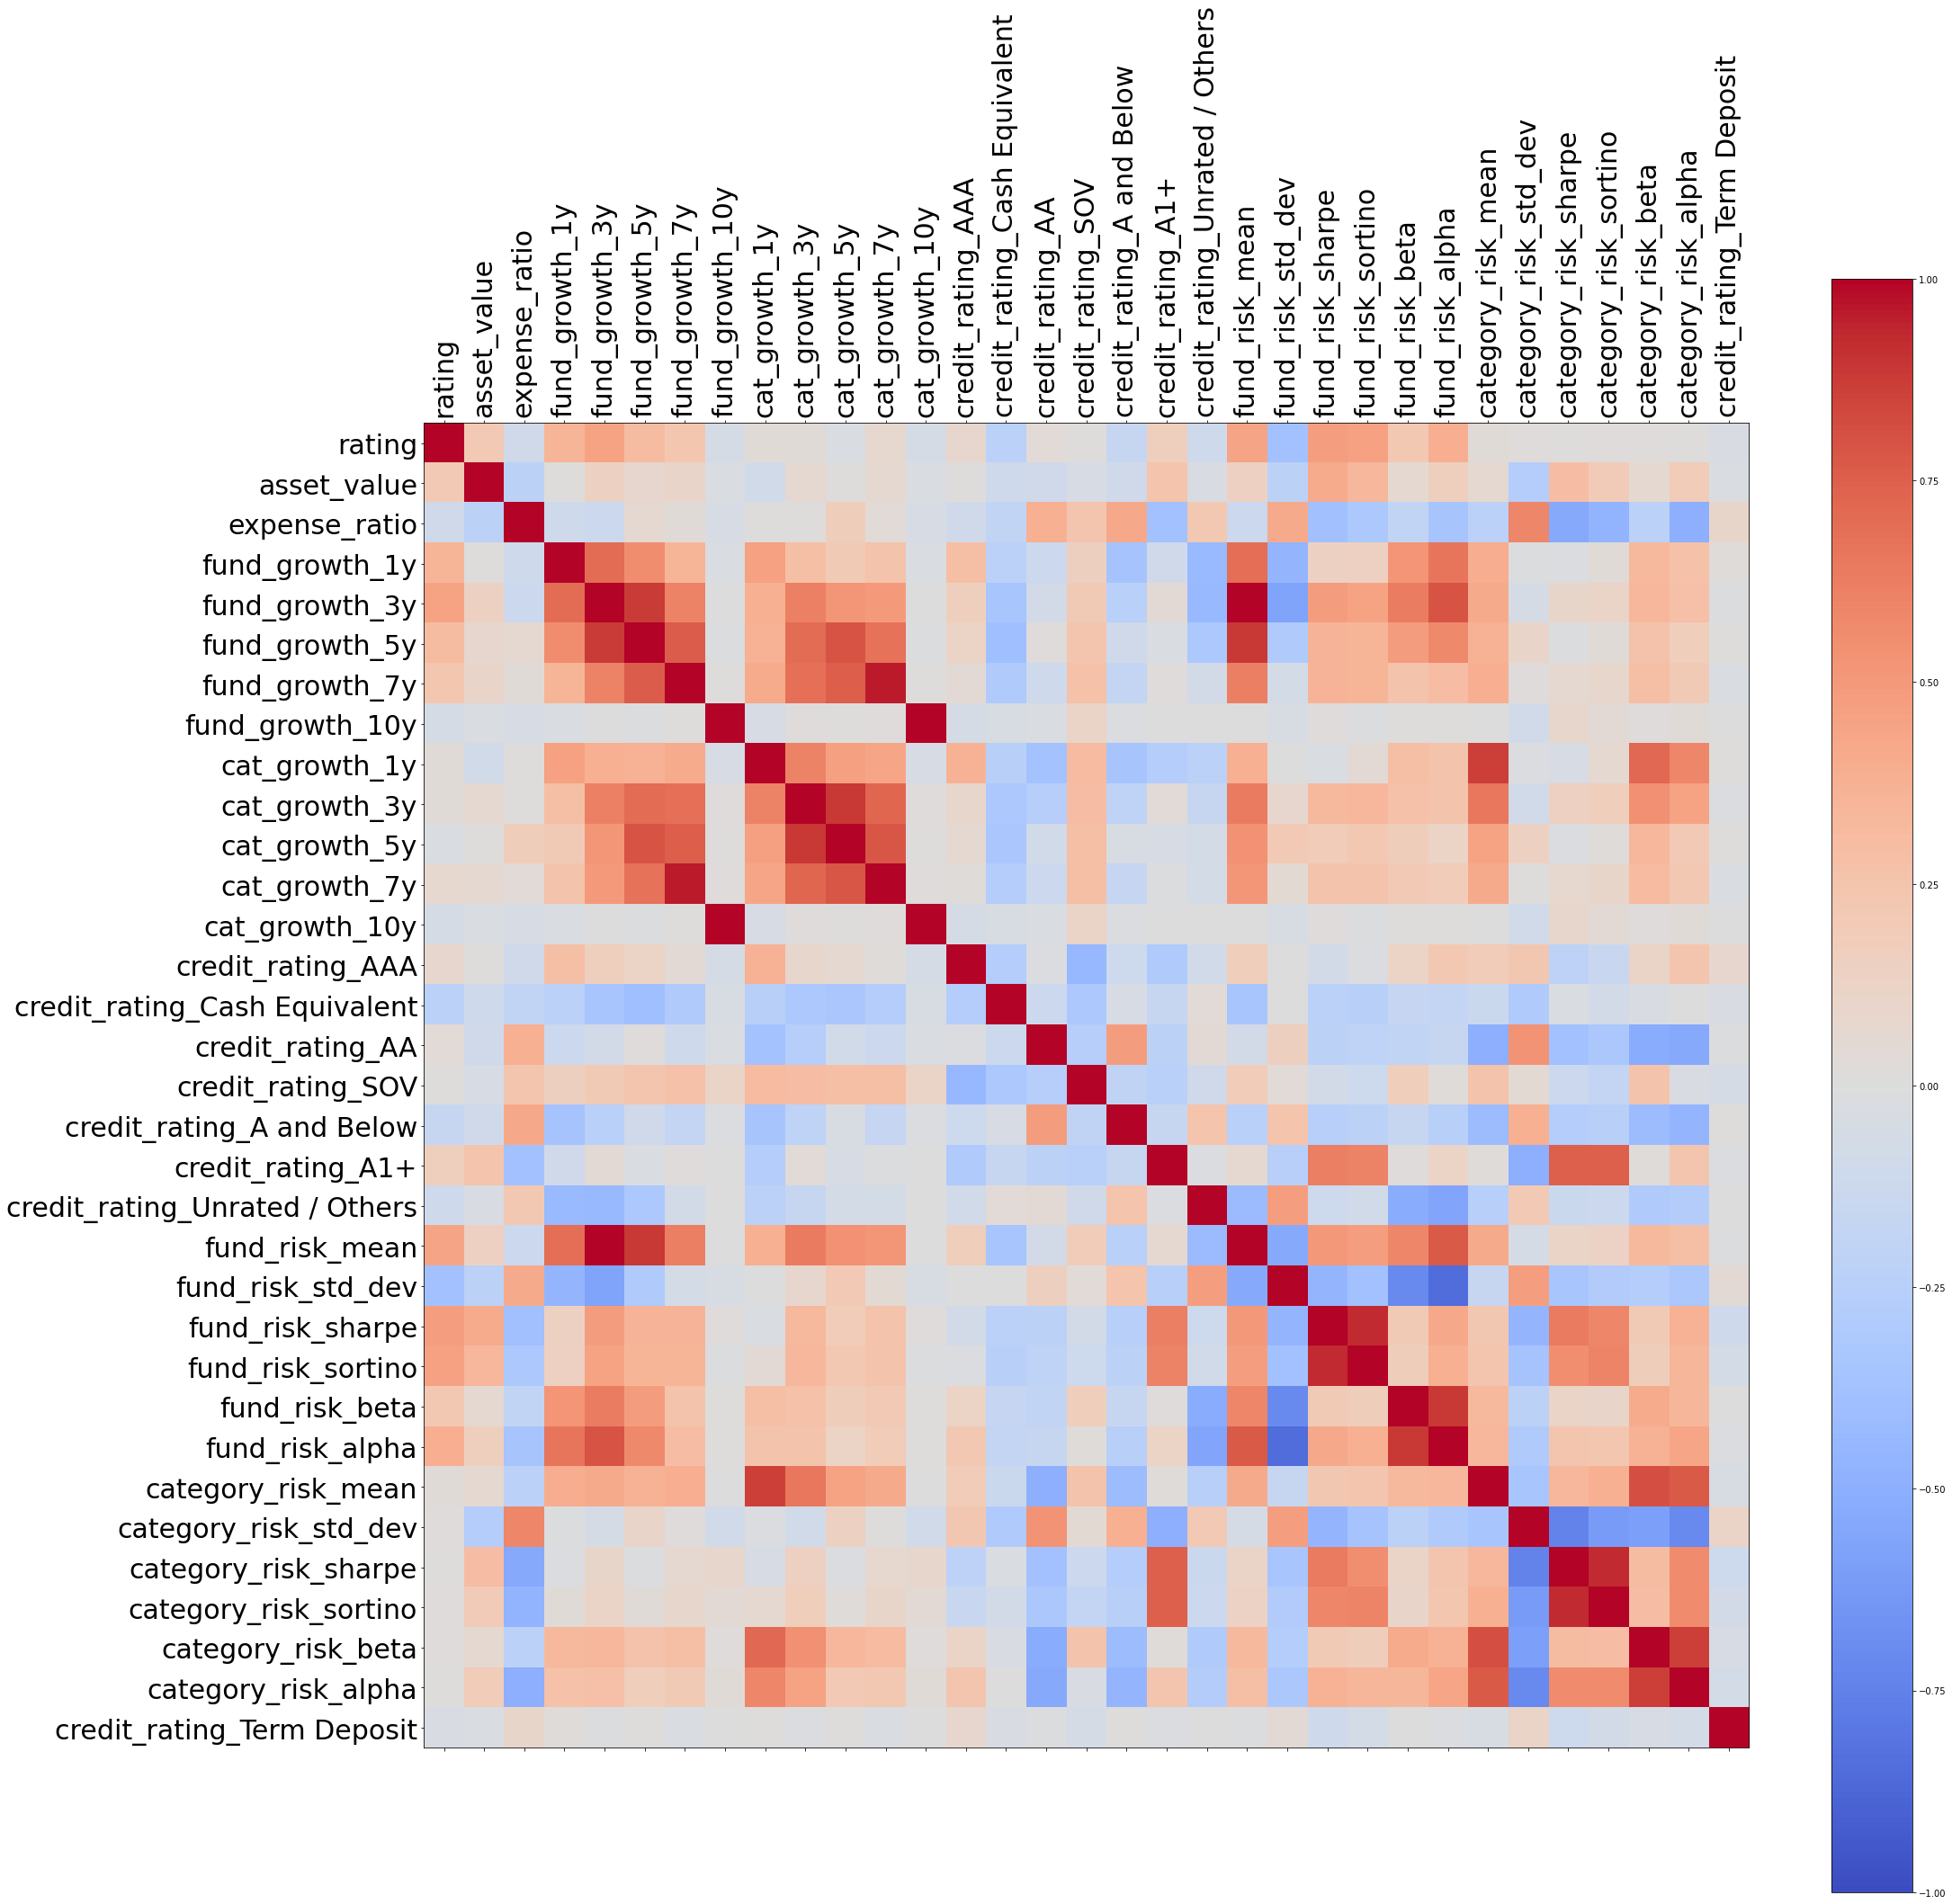

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

corr = df.select(input_columns).toPandas().corr()
fig = plt.figure(figsize=(len(input_columns), len(input_columns)))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(input_columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(input_columns, fontsize=30)
ax.set_yticklabels(input_columns, fontsize=30)
plt.show()

In [38]:
from pyspark.sql.functions import *

def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where((col(k).isNull())).count()
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_calc_list = null_value_calc(df)
if null_columns_calc_list:
    spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()
else:
    print("No null values")

No null values


In [43]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- link: string (nullable = true)
 |-- rating: long (nullable = true)
 |-- category: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- asset_value: long (nullable = true)
 |-- expense_ratio: double (nullable = true)
 |-- fund_house: string (nullable = true)
 |-- risk: string (nullable = true)
 |-- risk_grade: string (nullable = true)
 |-- return_grade: string (nullable = true)
 |-- top_holdings: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- fund_growth_1y: double (nullable = true)
 |-- fund_growth_3y: double (nullable = true)
 |-- fund_growth_5y: double (nullable = true)
 |-- fund_growth_7y: double (nullable = true)
 |-- fund_growth_10y: long (nullable = true)
 |-- cat_growth_1y: double (nullable = true)
 |-- cat_growth_3y: double (nullable = true)
 |-- cat_growth_5y: double (nullable = true)
 |-- cat_growth_7y: double (nullable = true)
 |-- cat_growth_10y: long (nullable = true)
 |-- cre

In [129]:
ranked.select("name","best_rank","risk","risk_num","expense_ratio","expense_ratio_rank","asset_value","asset_value_rank").orderBy(ranked["best_rank"]).show(100)

# ranked.select("name","expense_ratio","expense_ratio_rank","asset_value","asset_value_rank").orderBy(ranked["expense_ratio_rank"],ranked["asset_value_rank"]).show(10)
# ranked.filter("expense_ratio == 1").limit(1).toPandas()

+--------------------+---------+--------------+--------+-------------+------------------+-----------+----------------+
|                name|best_rank|          risk|risk_num|expense_ratio|expense_ratio_rank|asset_value|asset_value_rank|
+--------------------+---------+--------------+--------+-------------+------------------+-----------+----------------+
|     HDFC Liquid Dir|        1|           Low|     2.0|          0.2|                 1|      80165|               1|
|ICICI Pru Liquid Dir|        2|           Low|     2.0|          0.2|                 1|      54052|               2|
|      SBI Liquid Dir|        3|           Low|     2.0|         0.18|                 1|      51046|               3|
|     ABSL Liquid Dir|        4|           Low|     2.0|         0.21|                 1|      39810|               4|
|    Kotak Liquid Dir|        5|           Low|     2.0|          0.2|                 1|      31752|               5|
|     Axis Liquid Dir|        6|           Low| 

In [177]:
df = df.withColumn("expense_ratio_rank",when(df.expense_ratio <= 0.5, 1).when((0.5 < df.expense_ratio) & (df.expense_ratio <= 1) , 2).when((1 < df.expense_ratio) & (df.expense_ratio <= 1.5) , 3).otherwise(4))

In [220]:
df = df.withColumn("cr2",when(df.credit_rating_AA >= 80, 4).when((50 < df.credit_rating_AA) & (df.credit_rating_AA < 80) , 5).otherwise(6))

In [308]:
df.groupBy("category_code").count().orderBy('count').show()

+-------------+-----+
|category_code|count|
+-------------+-----+
|   DT-OVERNHT|   10|
|   DT-M to LD|   14|
|        DT-MD|   16|
|  DT-BK & PSU|   17|
|        DT-MM|   17|
|        DT-CR|   18|
|        DT-CB|   19|
|        DT-GL|   21|
|       DT-USD|   23|
|        DT-LD|   25|
|        DT-DB|   26|
|        DT-SD|   27|
|       DT-LIQ|   36|
+-------------+-----+



In [202]:

#         .withColumn("cr2",dense_rank().over(Window.orderBy(df['credit_rating_AA'].desc())))

In [222]:
# ranked = df.withColumn("credit_rating_rank", row_number().over(Window.orderBy(df['cr1'],df['cr2'])))

ranked = df.withColumn("credit_rating_rank", dense_rank().over(Window.partitionBy('cr2').orderBy(df['cr1'].desc())))

ranked.select('credit_rating_rank','cr1','cr2','credit_rating_AAA','credit_rating_AA').show()

+------------------+---+---+-----------------+----------------+
|credit_rating_rank|cr1|cr2|credit_rating_AAA|credit_rating_AA|
+------------------+---+---+-----------------+----------------+
|                 1|169|  5|             4.17|            52.9|
|                 2|144|  5|            14.43|           79.92|
|                 3|135|  5|            18.55|           56.93|
|                 4|126|  5|            21.28|           60.43|
|                 1|183|  6|              0.0|             0.0|
|                 1|183|  6|              0.0|             0.0|
|                 1|183|  6|              0.0|             0.0|
|                 1|183|  6|              0.0|             0.0|
|                 1|183|  6|              0.0|             0.0|
|                 1|183|  6|              0.0|             0.0|
|                 1|183|  6|              0.0|             0.0|
|                 1|183|  6|              0.0|             0.0|
|                 1|183|  6|            

In [215]:
ranked.select("credit_rating_rank","credit_rating_AAA","credit_rating_AA").show()

+------------------+-----------------+----------------+
|credit_rating_rank|credit_rating_AAA|credit_rating_AA|
+------------------+-----------------+----------------+
|                 1|             4.17|            52.9|
|                 1|            14.43|           79.92|
|                 1|            18.55|           56.93|
|                 1|            21.28|           60.43|
|                 2|            10.85|            0.03|
|                 2|            22.65|           41.44|
|                 2|            27.38|            26.8|
|                 2|              0.0|             0.0|
|                 2|            68.85|            2.11|
|                 2|            35.22|            9.33|
|                 2|            61.52|            7.55|
|                 2|            93.96|             0.0|
|                 2|            71.78|             0.0|
|                 2|            29.72|           47.24|
|                 2|              0.0|          

In [145]:
from pyspark.ml.feature import QuantileDiscretizer
result_discretizer = QuantileDiscretizer(numBuckets=4, inputCol="credit_rating_AAA",outputCol="credit_rating_bucket").fit(df).transform(df)
result_discretizer.select("credit_rating_AAA","credit_rating_bucket").filter('credit_rating_bucket == 3').orderBy('credit_rating_AAA').show()

+-----------------+--------------------+
|credit_rating_AAA|credit_rating_bucket|
+-----------------+--------------------+
|            44.69|                 3.0|
|            45.26|                 3.0|
|            45.82|                 3.0|
|            46.63|                 3.0|
|            46.64|                 3.0|
|            48.06|                 3.0|
|            49.37|                 3.0|
|            51.15|                 3.0|
|            52.98|                 3.0|
|            55.32|                 3.0|
|            55.42|                 3.0|
|            56.05|                 3.0|
|            57.07|                 3.0|
|            57.25|                 3.0|
|            57.56|                 3.0|
|            58.49|                 3.0|
|            58.57|                 3.0|
|            59.71|                 3.0|
|            60.09|                 3.0|
|            60.48|                 3.0|
+-----------------+--------------------+
only showing top

In [126]:
from pyspark.ml.feature import StringIndexer
for column in df.columns[2:]:       
    if str(df.schema[column].dataType) == 'StringType':
        indexer = StringIndexer(inputCol=column, outputCol=column+"_num") 
        df = indexer.fit(df).transform(df)
        
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- link: string (nullable = true)
 |-- rating: long (nullable = true)
 |-- category: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- asset_value: long (nullable = true)
 |-- expense_ratio: double (nullable = true)
 |-- fund_house: string (nullable = true)
 |-- risk: string (nullable = true)
 |-- risk_grade: string (nullable = true)
 |-- return_grade: string (nullable = true)
 |-- top_holdings: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- fund_growth_1y: double (nullable = true)
 |-- fund_growth_3y: double (nullable = true)
 |-- fund_growth_5y: double (nullable = true)
 |-- fund_growth_7y: double (nullable = true)
 |-- fund_growth_10y: double (nullable = true)
 |-- cat_growth_1y: double (nullable = true)
 |-- cat_growth_3y: double (nullable = true)
 |-- cat_growth_5y: double (nullable = true)
 |-- cat_growth_7y: double (nullable = true)
 |-- cat_growth_10y: double (nullable = true)
 |--

In [42]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import numpy as np
from pyspark.ml.feature import MinMaxScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [62]:
input_columns= []
for col in df.columns:
    if str(df.schema[col].dataType) in ('IntegerType', 'DoubleType','LongType'):
        input_columns.append(col)
input_columns

['rating',
 'asset_value',
 'expense_ratio',
 'fund_growth_1y',
 'fund_growth_3y',
 'fund_growth_5y',
 'fund_growth_7y',
 'fund_growth_10y',
 'cat_growth_1y',
 'cat_growth_3y',
 'cat_growth_5y',
 'cat_growth_7y',
 'cat_growth_10y',
 'credit_rating_AAA',
 'credit_rating_Cash Equivalent',
 'credit_rating_AA',
 'credit_rating_SOV',
 'credit_rating_A and Below',
 'credit_rating_A1+',
 'credit_rating_Unrated / Others',
 'fund_risk_mean',
 'fund_risk_std_dev',
 'fund_risk_sharpe',
 'fund_risk_sortino',
 'fund_risk_beta',
 'fund_risk_alpha',
 'category_risk_mean',
 'category_risk_std_dev',
 'category_risk_sharpe',
 'category_risk_sortino',
 'category_risk_beta',
 'category_risk_alpha',
 'credit_rating_Term Deposit']

In [311]:
df.limit(2).toPandas()
df.columns

['name',
 'link',
 'rating',
 'category',
 'category_code',
 'asset_value',
 'expense_ratio',
 'fund_house',
 'risk',
 'risk_grade',
 'return_grade',
 'top_holdings',
 'fund_growth_1y',
 'fund_growth_3y',
 'fund_growth_5y',
 'fund_growth_7y',
 'fund_growth_10y',
 'cat_growth_1y',
 'cat_growth_3y',
 'cat_growth_5y',
 'cat_growth_7y',
 'cat_growth_10y',
 'credit_rating_A1+',
 'credit_rating_SOV',
 'credit_rating_AAA',
 'credit_rating_Cash Equivalent',
 'credit_rating_AA',
 'credit_rating_A and Below',
 'credit_rating_Unrated / Others',
 'credit_rating_Term Deposit',
 'trend_growth',
 'credit_rating_rank',
 'asset_value_rank',
 'expense_ratio_rank',
 'risk_rank']

In [43]:
# input_columns = ['risk_rank','credit_rating_rank' ,'asset_value_rank' , 'expense_ratio_rank' , 'trend_growth']
vecAssembler = VectorAssembler(inputCols = input_columns, outputCol="features")
final_df = vecAssembler.transform(df)
final_df.show(2,False)

+--------------------------------------+-----------------------------------------------------------------------------------+------+--------------------+-------------+-----------+-------------+---------------------------------+--------------+-------------+-------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+--------------+--------------+--------------+---------------+-------------+-------------+-------------+-------------+--------------+-----------------+-----------------------------+----------------+-----------------+-------------------------+-----------------+------------------------------+--------------+-----------------+----------------+-----------------+--------------+--

Text(0, 0.5, 'cost')

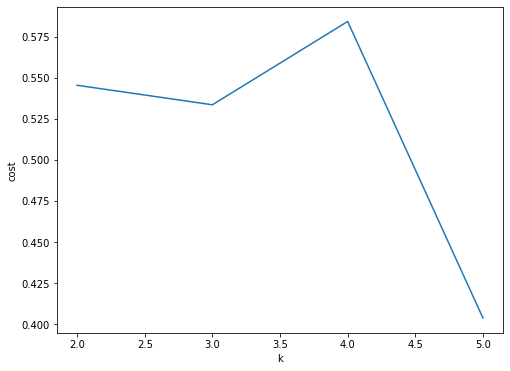

In [323]:
from pyspark.ml.evaluation import ClusteringEvaluator

# set a max for the number of clusters you want to try out
kmax = 6
# Create and array filled with zeros for the amount of k
# Similar to creating an empty list
kmcost = np.zeros(kmax)
for k in range(2,kmax):
    # Set up the k-means alogrithm
    kmeans = KMeans(initSteps=4, tol=1e-4, maxIter=20).setK(k).setSeed(1).setFeaturesCol("features")
    # Fit it on your dataframe
    model = kmeans.fit(final_df.sample(False, 0.1, seed=42))
    # Make predictions
    predictions = model.transform(final_df)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    kmcost[k] = evaluator.evaluate(predictions)
    # Fill in the zeros of your array with cost....
    # Computes the "cost" (sum of squared distances) between the input points and their corresponding cluster centers.
    # kmcost[k] = model.computeCost(final_df) # requires Spark 2.0 or later


# Set up the plot dimensions
fig, ax = plt.subplots(1,1, figsize =(8,6))
# Then specify the range of values for the axis and call on your cost array
ax.plot(range(2,kmax),kmcost[2:kmax])
# Set up the axis labels
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [330]:
k = 3
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(final_df)

# bkmeans = BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("features")
# model = bkmeans.fit(df_kmeans)

# Make predictions
predictions = model.transform(final_df)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
print(" ")

# Shows the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
import pandas as pd

centerDF = pd.DataFrame(list(map(np.ravel,centers)))
centerDF.columns = input_columns
centerDF

Silhouette with squared euclidean distance = 0.5720356744532813
 
Cluster Centers: 


,risk_rank,credit_rating_rank,asset_value_rank,expense_ratio_rank,trend_growth
0,2.971014,49.086957,69.739130,30.144928,6.826087
1,2.827586,126.060345,200.698276,42.448276,7.922414
2,2.071429,170.130952,83.190476,27.333333,7.535714


In [331]:
transformed = model.transform(final_df).select('name','category','prediction','total_rank')
transformed.show(30)

AnalysisException: "cannot resolve '`total_rank`' given input columns: [risk_rank, fund_growth_7y, category, fund_growth_5y, fund_growth_1y, trend_growth, fund_house, credit_rating_SOV, link, prediction, top_holdings, rating, return_grade, name, cat_growth_5y, risk_grade, asset_value_rank, credit_rating_Term Deposit, cat_growth_1y, fund_growth_10y, risk, credit_rating_rank, cat_growth_3y, credit_rating_A and Below, cat_growth_7y, credit_rating_Unrated / Others, fund_growth_3y, credit_rating_Cash Equivalent, credit_rating_AA, credit_rating_AAA, asset_value, features, expense_ratio, category_code, credit_rating_A1+, expense_ratio_rank, cat_growth_10y];;\n'Project [name#47579, category#47582, prediction#49472, 'total_rank]\n+- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 13 more fields]\n   +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 12 more fields]\n      +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 11 more fields]\n         +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 10 more fields]\n            +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 11 more fields]\n               +- Window [dense_rank(expense_ratio#48229) windowspecdefinition(expense_ratio#48229 ASC NULLS FIRST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS expense_ratio_rank#48397], [expense_ratio#48229 ASC NULLS FIRST]\n                  +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 9 more fields]\n                     +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 9 more fields]\n                        +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 10 more fields]\n                           +- Window [dense_rank(asset_value#48228L) windowspecdefinition(asset_value#48228L DESC NULLS LAST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS asset_value_rank#48355], [asset_value#48228L DESC NULLS LAST]\n                              +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 8 more fields]\n                                 +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 8 more fields]\n                                    +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 9 more fields]\n                                       +- Window [dense_rank(credit_rating_AAA#48242) windowspecdefinition(credit_rating_AAA#48242 DESC NULLS LAST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS credit_rating_rank#48314], [credit_rating_AAA#48242 DESC NULLS LAST]\n                                          +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 7 more fields]\n                                             +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 7 more fields]\n                                                +- Project [name#47579, link#47580, CASE WHEN (cast(rating#47581L as double) = NaN) THEN cast(0.0 as bigint) ELSE rating#47581L END AS rating#48227L, category#47582, category_code#47583, CASE WHEN (cast(asset_value#47584L as double) = NaN) THEN cast(0.0 as bigint) ELSE asset_value#47584L END AS asset_value#48228L, CASE WHEN (expense_ratio#47585 = NaN) THEN cast(0.0 as double) ELSE expense_ratio#47585 END AS expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, CASE WHEN (fund_growth_1y#47639 = NaN) THEN cast(0.0 as double) ELSE fund_growth_1y#47639 END AS fund_growth_1y#48230, CASE WHEN (fund_growth_3y#47670 = NaN) THEN cast(0.0 as double) ELSE fund_growth_3y#47670 END AS fund_growth_3y#48231, CASE WHEN (fund_growth_5y#47701 = NaN) THEN cast(0.0 as double) ELSE fund_growth_5y#47701 END AS fund_growth_5y#48232, CASE WHEN (fund_growth_7y#47732 = NaN) THEN cast(0.0 as double) ELSE fund_growth_7y#47732 END AS fund_growth_7y#48233, CASE WHEN (fund_growth_10y#47763 = NaN) THEN cast(0.0 as double) ELSE fund_growth_10y#47763 END AS fund_growth_10y#48234, CASE WHEN (cat_growth_1y#47794 = NaN) THEN cast(0.0 as double) ELSE cat_growth_1y#47794 END AS cat_growth_1y#48235, CASE WHEN (cat_growth_3y#47825 = NaN) THEN cast(0.0 as double) ELSE cat_growth_3y#47825 END AS cat_growth_3y#48236, CASE WHEN (cat_growth_5y#47856 = NaN) THEN cast(0.0 as double) ELSE cat_growth_5y#47856 END AS cat_growth_5y#48237, CASE WHEN (cat_growth_7y#47887 = NaN) THEN cast(0.0 as double) ELSE cat_growth_7y#47887 END AS cat_growth_7y#48238, CASE WHEN (cat_growth_10y#47918 = NaN) THEN cast(0.0 as double) ELSE cat_growth_10y#47918 END AS cat_growth_10y#48239, CASE WHEN (credit_rating_A1+#47949 = NaN) THEN cast(0.0 as double) ELSE credit_rating_A1+#47949 END AS credit_rating_A1+#48240, CASE WHEN (credit_rating_SOV#47980 = NaN) THEN cast(0.0 as double) ELSE credit_rating_SOV#47980 END AS credit_rating_SOV#48241, ... 6 more fields]\n                                                   +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating_A1+#47949, credit_rating_SOV#47980, ... 6 more fields]\n                                                      +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating_A1+#47949, credit_rating_SOV#47980, ... 6 more fields]\n                                                         +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating_A1+#47949, credit_rating_SOV#47980, ... 6 more fields]\n                                                            +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating_A1+#47949, credit_rating_SOV#47980, ... 6 more fields]\n                                                               +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating_A1+#47949, credit_rating_SOV#47980, ... 6 more fields]\n                                                                  +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating_A1+#47949, credit_rating_SOV#47980, ... 6 more fields]\n                                                                     +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating_A1+#47949, credit_rating.SOV#47602 AS credit_rating_SOV#47980, ... 6 more fields]\n                                                                        +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating.A1+#47601 AS credit_rating_A1+#47949, credit_rating.SOV#47602, ... 6 more fields]\n                                                                           +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth.10y#47600 AS cat_growth_10y#47918, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                              +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth.7y#47599 AS cat_growth_7y#47887, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                 +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth.5y#47598 AS cat_growth_5y#47856, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                    +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth.3y#47597 AS cat_growth_3y#47825, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                       +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth.1y#47596 AS cat_growth_1y#47794, cat_growth.3y#47597, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                          +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth.10y#47595 AS fund_growth_10y#47763, cat_growth.1y#47596, cat_growth.3y#47597, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                             +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth.7y#47594 AS fund_growth_7y#47732, fund_growth.10y#47595, cat_growth.1y#47596, cat_growth.3y#47597, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                                +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth.5y#47593 AS fund_growth_5y#47701, fund_growth.7y#47594, fund_growth.10y#47595, cat_growth.1y#47596, cat_growth.3y#47597, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                                   +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth.3y#47592 AS fund_growth_3y#47670, fund_growth.5y#47593, fund_growth.7y#47594, fund_growth.10y#47595, cat_growth.1y#47596, cat_growth.3y#47597, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                                      +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth.1y#47591 AS fund_growth_1y#47639, fund_growth.3y#47592, fund_growth.5y#47593, fund_growth.7y#47594, fund_growth.10y#47595, cat_growth.1y#47596, cat_growth.3y#47597, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                                         +- LogicalRDD [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth.1y#47591, fund_growth.3y#47592, fund_growth.5y#47593, fund_growth.7y#47594, fund_growth.10y#47595, cat_growth.1y#47596, cat_growth.3y#47597, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields], false\n"

In [61]:
transformed.select('name', 'category').filter('prediction==2').show(100,False)

+-----------------------------------+--------------------------+
|name                               |category                  |
+-----------------------------------+--------------------------+
|ABSL Money Manager Dir             |Debt: Money Market        |
|ABSL Corporate Bond Dir            |Debt: Corporate Bond      |
|ABSL Savings Dir                   |Debt: Ultra Short Duration|
|Axis Banking & PSU Debt Dir        |Debt: Banking and PSU     |
|Axis Liquid Dir                    |Debt: Liquid              |
|Axis Short Term Dir                |Debt: Short Duration      |
|ABSL Banking & PSU Debt Dir        |Debt: Banking and PSU     |
|ABSL Low Duration Dir              |Debt: Low Duration        |
|DSP Liquidity Dir                  |Debt: Liquid              |
|HDFC Low Duration Dir              |Debt: Low Duration        |
|HDFC Overnight Dir                 |Debt: Overnight           |
|HDFC Short Term Debt Dir           |Debt: Short Duration      |
|HDFC Ultra Short Term Di

In [328]:
for pred in range(0,3):
    print(" ")
    print("Cluster: "+str(pred))
    uni_lst = transformed.select('name', 'category','total_rank').filter('prediction=='+str(pred))
    uni_lst.show(truncate=False)

 
Cluster: 0


AnalysisException: "cannot resolve '`total_rank`' given input columns: [name, category, prediction];;\n'Project [name#47579, category#47582, 'total_rank]\n+- Project [name#47579, category#47582, prediction#49239]\n   +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 13 more fields]\n      +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 12 more fields]\n         +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 11 more fields]\n            +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 10 more fields]\n               +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 11 more fields]\n                  +- Window [dense_rank(expense_ratio#48229) windowspecdefinition(expense_ratio#48229 ASC NULLS FIRST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS expense_ratio_rank#48397], [expense_ratio#48229 ASC NULLS FIRST]\n                     +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 9 more fields]\n                        +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 9 more fields]\n                           +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 10 more fields]\n                              +- Window [dense_rank(asset_value#48228L) windowspecdefinition(asset_value#48228L DESC NULLS LAST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS asset_value_rank#48355], [asset_value#48228L DESC NULLS LAST]\n                                 +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 8 more fields]\n                                    +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 8 more fields]\n                                       +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 9 more fields]\n                                          +- Window [dense_rank(credit_rating_AAA#48242) windowspecdefinition(credit_rating_AAA#48242 DESC NULLS LAST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS credit_rating_rank#48314], [credit_rating_AAA#48242 DESC NULLS LAST]\n                                             +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 7 more fields]\n                                                +- Project [name#47579, link#47580, rating#48227L, category#47582, category_code#47583, asset_value#48228L, expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#48230, fund_growth_3y#48231, fund_growth_5y#48232, fund_growth_7y#48233, fund_growth_10y#48234, cat_growth_1y#48235, cat_growth_3y#48236, cat_growth_5y#48237, cat_growth_7y#48238, cat_growth_10y#48239, credit_rating_A1+#48240, credit_rating_SOV#48241, ... 7 more fields]\n                                                   +- Project [name#47579, link#47580, CASE WHEN (cast(rating#47581L as double) = NaN) THEN cast(0.0 as bigint) ELSE rating#47581L END AS rating#48227L, category#47582, category_code#47583, CASE WHEN (cast(asset_value#47584L as double) = NaN) THEN cast(0.0 as bigint) ELSE asset_value#47584L END AS asset_value#48228L, CASE WHEN (expense_ratio#47585 = NaN) THEN cast(0.0 as double) ELSE expense_ratio#47585 END AS expense_ratio#48229, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, CASE WHEN (fund_growth_1y#47639 = NaN) THEN cast(0.0 as double) ELSE fund_growth_1y#47639 END AS fund_growth_1y#48230, CASE WHEN (fund_growth_3y#47670 = NaN) THEN cast(0.0 as double) ELSE fund_growth_3y#47670 END AS fund_growth_3y#48231, CASE WHEN (fund_growth_5y#47701 = NaN) THEN cast(0.0 as double) ELSE fund_growth_5y#47701 END AS fund_growth_5y#48232, CASE WHEN (fund_growth_7y#47732 = NaN) THEN cast(0.0 as double) ELSE fund_growth_7y#47732 END AS fund_growth_7y#48233, CASE WHEN (fund_growth_10y#47763 = NaN) THEN cast(0.0 as double) ELSE fund_growth_10y#47763 END AS fund_growth_10y#48234, CASE WHEN (cat_growth_1y#47794 = NaN) THEN cast(0.0 as double) ELSE cat_growth_1y#47794 END AS cat_growth_1y#48235, CASE WHEN (cat_growth_3y#47825 = NaN) THEN cast(0.0 as double) ELSE cat_growth_3y#47825 END AS cat_growth_3y#48236, CASE WHEN (cat_growth_5y#47856 = NaN) THEN cast(0.0 as double) ELSE cat_growth_5y#47856 END AS cat_growth_5y#48237, CASE WHEN (cat_growth_7y#47887 = NaN) THEN cast(0.0 as double) ELSE cat_growth_7y#47887 END AS cat_growth_7y#48238, CASE WHEN (cat_growth_10y#47918 = NaN) THEN cast(0.0 as double) ELSE cat_growth_10y#47918 END AS cat_growth_10y#48239, CASE WHEN (credit_rating_A1+#47949 = NaN) THEN cast(0.0 as double) ELSE credit_rating_A1+#47949 END AS credit_rating_A1+#48240, CASE WHEN (credit_rating_SOV#47980 = NaN) THEN cast(0.0 as double) ELSE credit_rating_SOV#47980 END AS credit_rating_SOV#48241, ... 6 more fields]\n                                                      +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating_A1+#47949, credit_rating_SOV#47980, ... 6 more fields]\n                                                         +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating_A1+#47949, credit_rating_SOV#47980, ... 6 more fields]\n                                                            +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating_A1+#47949, credit_rating_SOV#47980, ... 6 more fields]\n                                                               +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating_A1+#47949, credit_rating_SOV#47980, ... 6 more fields]\n                                                                  +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating_A1+#47949, credit_rating_SOV#47980, ... 6 more fields]\n                                                                     +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating_A1+#47949, credit_rating_SOV#47980, ... 6 more fields]\n                                                                        +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating_A1+#47949, credit_rating.SOV#47602 AS credit_rating_SOV#47980, ... 6 more fields]\n                                                                           +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth_10y#47918, credit_rating.A1+#47601 AS credit_rating_A1+#47949, credit_rating.SOV#47602, ... 6 more fields]\n                                                                              +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth_7y#47887, cat_growth.10y#47600 AS cat_growth_10y#47918, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                 +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth_5y#47856, cat_growth.7y#47599 AS cat_growth_7y#47887, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                    +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth_3y#47825, cat_growth.5y#47598 AS cat_growth_5y#47856, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                       +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth_1y#47794, cat_growth.3y#47597 AS cat_growth_3y#47825, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                          +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth_10y#47763, cat_growth.1y#47596 AS cat_growth_1y#47794, cat_growth.3y#47597, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                             +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth_7y#47732, fund_growth.10y#47595 AS fund_growth_10y#47763, cat_growth.1y#47596, cat_growth.3y#47597, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                                +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth_5y#47701, fund_growth.7y#47594 AS fund_growth_7y#47732, fund_growth.10y#47595, cat_growth.1y#47596, cat_growth.3y#47597, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                                   +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth_3y#47670, fund_growth.5y#47593 AS fund_growth_5y#47701, fund_growth.7y#47594, fund_growth.10y#47595, cat_growth.1y#47596, cat_growth.3y#47597, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                                      +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth_1y#47639, fund_growth.3y#47592 AS fund_growth_3y#47670, fund_growth.5y#47593, fund_growth.7y#47594, fund_growth.10y#47595, cat_growth.1y#47596, cat_growth.3y#47597, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                                         +- Project [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth.1y#47591 AS fund_growth_1y#47639, fund_growth.3y#47592, fund_growth.5y#47593, fund_growth.7y#47594, fund_growth.10y#47595, cat_growth.1y#47596, cat_growth.3y#47597, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields]\n                                                                                                            +- LogicalRDD [name#47579, link#47580, rating#47581L, category#47582, category_code#47583, asset_value#47584L, expense_ratio#47585, fund_house#47586, risk#47587, risk_grade#47588, return_grade#47589, top_holdings#47590, fund_growth.1y#47591, fund_growth.3y#47592, fund_growth.5y#47593, fund_growth.7y#47594, fund_growth.10y#47595, cat_growth.1y#47596, cat_growth.3y#47597, cat_growth.5y#47598, cat_growth.7y#47599, cat_growth.10y#47600, credit_rating.A1+#47601, credit_rating.SOV#47602, ... 6 more fields], false\n"

In [349]:
from pyspark.ml.regression import LinearRegression

train, test = final_df.randomSplit([0.7,0.3])
lr = LinearRegression(featuresCol = 'features', labelCol='total_rank', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.4979557111556542,0.9941121279480928,0.9993011677906541,0.9983886977199034,0.8837861939111883]
Intercept: 3.0423134910052356


In [350]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.505390
r2: 0.999980


In [351]:
lr_predictions = lr_model.transform(test)
lr_predictions.select("prediction","total_rank","features").show(5,False)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="total_rank",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----------+-------------------------+
|prediction        |total_rank|features                 |
+------------------+----------+-------------------------+
|76.50754371860245 |76        |[3.0,28.0,12.0,26.0,7.0] |
|229.38333589474666|230       |[3.0,117.0,97.0,1.0,12.0]|
|152.99300462478206|153       |[3.0,94.0,19.0,29.0,8.0] |
|160.34357698493153|160       |[3.0,46.0,65.0,39.0,7.0] |
|188.45185561066748|188       |[3.0,24.0,130.0,24.0,7.0]|
+------------------+----------+-------------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.999979


In [352]:
test_result = lr_model.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 0.463872
